In [1]:
"""# Imports de bibliotecas"""

from qiskit import Aer
from qiskit.utils import algorithm_globals
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.utils import QuantumInstance
from qiskit_optimization.problems.variable import VarType
from re import match
from bisect import bisect_right

from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms.optimizers import SPSA

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'qiskit'

In [ ]:
"""#Funcions"""

def get_jss_bqm(job_dict, max_time=None, stitch_kwargs=None):
    if stitch_kwargs == None:
        stitch_kwargs = {}

    scheduler = JobShopScheduler(job_dict, max_time)
    return scheduler.get_bqm(stitch_kwargs)

def fix_format(*args):
    vals = {}
    for i in range(len(args)):
      vals[args[i].name]=1
    return vals

def get_label(task, time):
    return f"{task.job}_{task.position},{time}".format(**locals())

def getIndexs(binary_vars, current, next):
  curIndexi = 0
  curIndexj = 0
  nextIndexi = 0
  nextIndexj = 0
  indexi = 0
  indexj = 0
  for vars in binary_vars:
      indexj = 0
      for var in vars:
          if(current == var.name):
            curIndexi = indexi
            curIndexj = indexj
          if(next == var.name):
            nextIndexi = indexi
            nextIndexj = indexj
          indexj = indexj + 1
      indexi = indexi + 1
  return curIndexi, curIndexj, nextIndexi, nextIndexj

def fix_variable(var, value):
    var.set_initial_value(value)
    var.lb = value
    var.ub = value

def getLinearExp(binary_vars, current_label, next_label):
    curIndexi, curIndexj, nextIndexi, nextIndexj = getIndexs(binary_vars, current_label, next_label)
    linearExp = [binary_vars[curIndexi][curIndexj], binary_vars[nextIndexi][nextIndexj]]

    return linearExp

def fix_output(result):
    data = {}
    f = 0
    for i in range(len(result.variables)):
      if(result.x[i] == 1):
        string = f"{result.variables[i]}"
        string = string.split(' ')
        string = string[0].split(',')

        job = string[0]
        startTime = int(string[1])

        job = job.split('_')

        jobName = job[0]+"_"+job[1]
        taskName = job[2]

        timeToDone = Jobs[str(jobName)][int(taskName)][1]
        endTime = timeToDone + startTime

        machine = Jobs[str(jobName)][int(taskName)][0]

        data[f"{f}"] = {
            "job" : jobName,
            "task" : taskName,
            "startTime" : startTime,
            "endTime" : endTime,
            "machine" : machine,
            "value": result.x[i],
        } 
        f = f + 1

    return data

def plot_gantt_chart(data):
    colors = ['g', 'r', 'c', 'm', 'y', 'k']  # Cores para cada tarefa

    fig, ax = plt.subplots()

    for i,index in enumerate(data):
        machine = data[str(index)]['machine']
        start_time = data[str(index)]['startTime']
        duration = data[str(index)]['endTime'] - start_time
        end_time = start_time + duration
        
        if(data[str(index)]['job'] == 'job_1'):
            ax.barh(machine, duration, left=start_time, height=0.5, color='r')
            ax.text(start_time + duration / 2, machine, f'Op{jobs_dict["job_1"]+1}', ha='center', va='center')
            jobs_dict["job_1"] += 1
        elif(data[str(index)]['job'] == 'job_2'):
            ax.barh(machine, duration, left=start_time, height=0.5, color='g')
            ax.text(start_time + duration / 2, machine, f'Op{jobs_dict["job_2"]+1}', ha='center', va='center')
            jobs_dict["job_2"] += 1
        elif(data[str(index)]['job'] == 'job_3'):
            ax.barh(machine, duration, left=start_time, height=0.5, color='c')
            ax.text(start_time + duration / 2, machine, f'Op{jobs_dict["job_3"]+1}', ha='center', va='center')
            jobs_dict["job_3"] += 1
        elif(data[str(index)]['job'] == 'job_4'):
            ax.barh(machine, duration, left=start_time, height=0.5, color='m')
            ax.text(start_time + duration / 2, machine, f'Op{jobs_dict["job_4"]+1}', ha='center', va='center')
            jobs_dict["job_4"] += 1
        elif(data[str(index)]['job'] == 'job_5'):
            ax.barh(machine, duration, left=start_time, height=0.5, color='y')
            ax.text(start_time + duration / 2, machine, f'Op{jobs_dict["job_5"]+1}', ha='center', va='center')
            jobs_dict["job_5"] += 1

    ax.set_xlabel('Tempo')
    ax.set_ylabel('Máquina')
    ax.set_title('Gráfico de Gantt')

    plt.yticks(range(0, 3))
    plt.grid(True)
    plt.show()

In [ ]:
class Task:
    def __init__(self, job, position, machine, duration):
        self.job = job
        self.position = position
        self.machine = machine
        self.duration = duration

    def __repr__(self):
        return ("{{job: {job}, position: {position}, machine: {machine}, duration:"
                " {duration}}}").format(**vars(self))

class KeyList:
    def __init__(self, array, key_function):
        self.array = array
        self.key_function = key_function

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        item = self.array[index]
        key = self.key_function(item)
        return key

In [ ]:
"""# Criando o problema"""
class JobShopScheduler:
    def __init__(self, job_dict, max_time=None):
        self.tasks = []
        self.last_task_indices = []
        self.binary_vars = []
        self.labels = []
        self.max_time = max_time
        self.model = QuadraticProgram("JSSP")

        # Populates self.tasks and self.max_time
        self._process_data(job_dict)

    def _process_data(self, jobs):
        tasks = []
        last_task_indices = [-1]
        total_time = 0
        max_job_time = 0

        for job_name, job_tasks in jobs.items():
            last_task_indices.append(last_task_indices[-1] + len(job_tasks))
            job_time = 0

            for i, (machine, time_span) in enumerate(job_tasks):
                tasks.append(Task(job_name, i, machine, time_span))
                total_time += time_span
                job_time += time_span

            if job_time > max_job_time:
                max_job_time = job_time

        self.tasks = tasks
        self.last_task_indices = last_task_indices[1:]
        self.max_job_time = max_job_time - 1

        if self.max_time is None:
            self.max_time = total_time
        self.max_time -= 1
        
    
    def remove_absurd_times(self):
        """Sets impossible task times in self.modelcsp to 0.
        """
        predecessor_time = 0
        current_job = self.tasks[0].job
        for task in self.tasks:
            # Check if task is in current_job
            if task.job != current_job:
                predecessor_time = 0
                current_job = task.job

            for t in range(predecessor_time):
                label = get_label(task, t)
                self.labels.append(label)

            predecessor_time += task.duration

        successor_time = -1
        current_job = self.tasks[-1].job
        for task in self.tasks[::-1]:
            # Check if task is in current_job
            if task.job != current_job:
                successor_time = -1
                current_job = task.job

            successor_time += task.duration
            for t in range(successor_time):
                label = get_label(task, self.max_time - t)
                self.labels.append(label)

                
    def add_one_start_constraint(self):
        """
              A task can start once and only once
        """
        taskId = 0
        for task in self.tasks:
            task_times = []
            for t in range(self.max_time + 1):
                label = get_label(task, t)
                if(label not in self.labels):
                    task_times.append(self.model.binary_var(name=label))
            self.binary_vars.append(task_times)
            linearExp = fix_format(*self.binary_vars[-1])
            self.model.linear_constraint(linear=linearExp, sense="==", rhs=1, name=f'one_start_constraint_job_{taskId}') 
            taskId = taskId + 1
        
        
    def add_precedence_constraint(self):
        """
              self.modelcsp gets the constraint: Task must follow a particular order.
              Note: assumes self.tasks are sorted by jobs and then by position
        """
        id = 0
        for current_task, next_task in zip(self.tasks, self.tasks[1:]):
            if current_task.job != next_task.job:
                continue

            # Forming constraints with the relevant times of the next task
            for t in range(self.max_time + 1):
                current_label = get_label(current_task, t)

                for tt in range(min(t + current_task.duration, self.max_time + 1)):
                    next_label = get_label(next_task, tt)
                    if((current_label not in self.labels) and (next_label not in self.labels)):
                        linearExp = getLinearExp(self.binary_vars, current_label, next_label)
                        self.model.linear_constraint(linear=fix_format(*linearExp), sense="<=", rhs=1, name=f'add_precedence_constraint_{id}')
                        id = id + 1


    def add_share_machine_constraint(self):
        """
            self.modelcsp gets the constraint: At most one task per machine per time
        """
        sorted_tasks = sorted(self.tasks, key=lambda x: x.machine)
        wrapped_tasks = KeyList(sorted_tasks, lambda x: x.machine) # Key wrapper for bisect function

        head = 0
        id = 0
        while head < len(sorted_tasks):

            # Find tasks that share a machine
            tail = bisect_right(wrapped_tasks, sorted_tasks[head].machine)
            same_machine_tasks = sorted_tasks[head:tail]

            # Update
            head = tail

            # No need to build coupling for a single task
            if len(same_machine_tasks) < 2:
                continue

            # Apply constraint between all tasks for each unit of time
            for task in same_machine_tasks:
                for other_task in same_machine_tasks:
                    if task.job == other_task.job and task.position == other_task.position:
                        continue
                    for t in range(self.max_time + 1):
                        current_label = get_label(task, t)

                        for tt in range(t, min(t + task.duration, self.max_time + 1)):
                            other_label = get_label(other_task, tt)
                            if((current_label not in self.labels) and (other_label not in self.labels)):
                                linearExp = getLinearExp(self.binary_vars, current_label, other_label)
                                self.model.linear_constraint(linear=fix_format(*linearExp), sense="<=", rhs=1, name=f'add_share_machine_constraint_{id}')
                                id = id + 1

    def get_bqm(self, stitch_kwargs=None):
        if stitch_kwargs is None:
            stitch_kwargs = {}

        # Apply constraints to self.model
        self.remove_absurd_times()
        print("Variaveis que foram retiradas", self.labels)
        self.add_one_start_constraint()
        self.add_precedence_constraint()
        self.add_share_machine_constraint()

        return self.model

def is_auxiliary_variable(v):
    return match("aux\d+$", v)

In [ ]:
"""# Instancia de Teste"""

Jobs = {'job_1': [('machine_2', 2), ('machine_1', 1)],
        'job_2': [('machine_1', 1), ('machine_2', 1)]}

max_time = 4

#machine_1 = 5
#machine_2 = 5
#machine_3 = 5
#machine_4 = 5


In [ ]:
qp = get_jss_bqm(Jobs, max_time)

Variaveis que foram retiradas ['job_1_1,0', 'job_1_1,1', 'job_2_1,0', 'job_2_0,3', 'job_1_0,3', 'job_1_0,2']


In [ ]:
print(qp.prettyprint())

Problem name: JSSP

Minimize
  0

Subject to
  Linear constraints (14)
    job_1_0,0 + job_1_0,1 == 1  'one_start_constraint_job_0'
    job_1_1,2 + job_1_1,3 == 1  'one_start_constraint_job_1'
    job_2_0,0 + job_2_0,1 + job_2_0,2 == 1  'one_start_constraint_job_2'
    job_2_1,1 + job_2_1,2 + job_2_1,3 == 1  'one_start_constraint_job_3'
    job_1_0,1 + job_1_1,2 <= 1  'add_precedence_constraint_0'
    job_2_0,1 + job_2_1,1 <= 1  'add_precedence_constraint_1'
    job_2_0,2 + job_2_1,1 <= 1  'add_precedence_constraint_2'
    job_2_0,2 + job_2_1,2 <= 1  'add_precedence_constraint_3'
    job_1_1,2 + job_2_0,2 <= 1  'add_share_machine_constraint_0'
    job_1_1,2 + job_2_0,2 <= 1  'add_share_machine_constraint_1'
    job_1_0,0 + job_2_1,1 <= 1  'add_share_machine_constraint_2'
    job_1_0,1 + job_2_1,1 <= 1  'add_share_machine_constraint_3'
    job_1_0,1 + job_2_1,2 <= 1  'add_share_machine_constraint_4'
    job_1_0,1 + job_2_1,1 <= 1  'add_share_machine_constraint_5'

  Binary variables (10

In [ ]:
"""# Gerando o QUBO"""

qubo = QuadraticProgramToQubo().convert(qp)
print(qubo.prettyprint())

Problem name: JSSP

Minimize
  11*job_1_0,0^2 + 22*job_1_0,0*job_1_0,1 + job_1_0,0*job_2_1,1 + 11*job_1_0,1^2
  + job_1_0,1*job_1_1,2 + 2*job_1_0,1*job_2_1,1 + job_1_0,1*job_2_1,2
  + 11*job_1_1,2^2 + 22*job_1_1,2*job_1_1,3 + 2*job_1_1,2*job_2_0,2
  + 11*job_1_1,3^2 + 11*job_2_0,0^2 + 22*job_2_0,0*job_2_0,1
  + 22*job_2_0,0*job_2_0,2 + 11*job_2_0,1^2 + 22*job_2_0,1*job_2_0,2
  + job_2_0,1*job_2_1,1 + 11*job_2_0,2^2 + job_2_0,2*job_2_1,1
  + job_2_0,2*job_2_1,2 + 11*job_2_1,1^2 + 22*job_2_1,1*job_2_1,2
  + 22*job_2_1,1*job_2_1,3 + 11*job_2_1,2^2 + 22*job_2_1,2*job_2_1,3
  + 11*job_2_1,3^2 - 22*job_1_0,0 - 22*job_1_0,1 - 22*job_1_1,2 - 22*job_1_1,3
  - 22*job_2_0,0 - 22*job_2_0,1 - 22*job_2_0,2 - 22*job_2_1,1 - 22*job_2_1,2
  - 22*job_2_1,3 + 44

Subject to
  No constraints

  Binary variables (10)
    job_1_0,0 job_1_0,1 job_1_1,2 job_1_1,3 job_2_0,0 job_2_0,1 job_2_0,2
    job_2_1,1 job_2_1,2 job_2_1,3



In [ ]:
"""# Rodando o QAOA"""

algorithm_globals.random_seed = 12345

optimizer = COBYLA()
sampler = Sampler()

qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=1)
qaoa_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)

qaoa_result = qaoa_optimizer.solve(qubo)

print(qaoa_result.prettyprint())
print("Tempo total de execução (segundos): ", "{0:.2f}".format(qaoa_result.min_eigen_solver_result.optimizer_time))

objective function value: 0.0
variable values: job_1_0,0=1.0, job_1_0,1=0.0, job_1_1,2=1.0, job_1_1,3=0.0, job_2_0,0=1.0, job_2_0,1=0.0, job_2_0,2=0.0, job_2_1,1=0.0, job_2_1,2=1.0, job_2_1,3=0.0
status: SUCCESS
Tempo total de execução (segundos):  2.50


In [ ]:
data = fix_output(qaoa_result)

jobs_dict = {
    "job_1": 0,
    "job_2": 0,
    "job_3": 0,
    "job_4": 0,
    "job_5": 0,
}


for each in data:
  print(data[f'{each}'])

{'job': 'job_1', 'task': '0', 'startTime': 0, 'endTime': 2, 'machine': 'machine_2', 'value': 1.0}
{'job': 'job_1', 'task': '1', 'startTime': 2, 'endTime': 3, 'machine': 'machine_1', 'value': 1.0}
{'job': 'job_2', 'task': '0', 'startTime': 0, 'endTime': 1, 'machine': 'machine_1', 'value': 1.0}
{'job': 'job_2', 'task': '1', 'startTime': 2, 'endTime': 3, 'machine': 'machine_2', 'value': 1.0}


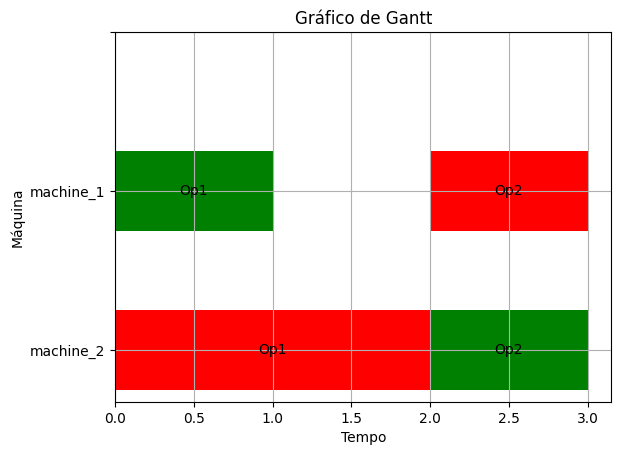

In [ ]:
plot_gantt_chart(data)